# Iris Dataset Machine Learning Analysis
In this project, I will be comparing the capabilities of various ML algorithms on the Iris Flower Dataset


#### Section 1: Data Loading & Preprocessing

In [87]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [111]:
# Loading Dataset
data_link = '../data/Iris.csv'
df = pd.read_csv(data_link)

# Splitting Train and Test Datasets
X = df.drop(["Id","Species"], axis=1)
y = df["Species"]
X_train_raw, X_test_raw, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)

# Normalizing data 
scaler= StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# PCA for 2D Plotting
pca_2d = PCA(n_components=2)
pca_2d.fit(X_train_scaled)
X_train_2d = pca_2d.transform(X_train_scaled)
X_test_2d = pca_2d.transform(X_test_scaled)

# Outputing Results
print(f"\nPCA Results:")
print(f"Original shape: {X_train_scaled.shape}")
print(f"PCA shape: {X_train_2d.shape}")
print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance preserved: {sum(pca_2d.explained_variance_ratio_):.4f}")


PCA Results:
Original shape: (120, 4)
PCA shape: (120, 2)
Explained variance ratio: [0.72454871 0.23273095]
Total variance preserved: 0.9573


#### Section 2: Model Training Functions

I have written two functions, evaluate_model() and plot_decision_boundaries(). evaluate_model() performs cross validation, fits the model, calculates various metrics, and returns info on the model's performance. plot_decision_boundary() uses the 2D data calculated from PCA to plot the decision boundaries that the model predicts

In [92]:
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test, X_train_2d, X_test_2d, plot_boundaries=True):
    # Cross-validation on training data (this trains internally)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Now fit once on full training set for final predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    test_accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Display results
    print(f"\n{'='*50}")
    print(f"{model_name} Results")
    print(f"{'='*50}")
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Individual CV scores: {cv_scores}")
    print(f"Test Set Accuracy: {test_accuracy:.3f}")
    print(f"\nClassification Report:\n{class_report}")

    # Display confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, 
               annot=True, 
               fmt='d',
               cmap='Blues',
               xticklabels=['Setosa', 'Versicolor', 'Virginica'],
               yticklabels=['Setosa', 'Versicolor', 'Virginica'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Plot decision boundaries
    if plot_boundaries:

        model_2d = clone(model)
        model_2d.fit(X_train_2d, y_train)

        plt.figure(figsize=(12, 8))
        plot_decision_boundaries(model_2d, X_train_2d, X_test_2d, y_train, y_test, model_name)
        plt.tight_layout()
        plt.show()
        
    # Return calculated data
    return {
        'model_name': model_name,
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': test_accuracy,
        'predictions': y_pred,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix
    }

def plot_decision_boundaries(model, X_train_2d, X_test_2d, y_train, y_test, model_name):
    # Combine data to plot
    X_2d = np.vstack([X_train_2d, X_test_2d])
    y_combined = np.hstack([y_train, y_test])

    # Create mesh grid for decision boundary
    step_size = 0.02
    x_min, x_max = X_2d[:,0].min() - 1, X_2d[:,0].max() + 1 
    y_min, y_max = X_2d[:,1].min() - 1, X_2d[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(mesh_points)

    if model_name == "XGBoost": 
        Z_numeric = Z.reshape(xx.shape)
    else:
        label_to_num = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
        Z_numeric = np.array([label_to_num[label] for label in Z])
        Z_numeric = Z_numeric.reshape(xx.shape)

    # Create custom colormap
    colors = ['#FF9999', '#66B2FF', '#99FF99']
    cmap = ListedColormap(colors)
    
    # Plot decision boundaries
    plt.contourf(xx, yy, Z_numeric, alpha=0.4, cmap=cmap, levels=np.arange(4)-0.5)
    
    # Plot all data points (combined train + test)
    if model_name == "XGBoost":
        X_setosa = X_2d[y_combined == 0]
        X_versicolor = X_2d[y_combined == 1]  
        X_virginica = X_2d[y_combined == 2]
    else:
        X_setosa = X_2d[y_combined == 'Iris-setosa']
        X_versicolor = X_2d[y_combined == 'Iris-versicolor']  
        X_virginica = X_2d[y_combined == 'Iris-virginica']
    
    plt.scatter(X_setosa[:, 0], X_setosa[:, 1], c='red', s=100, 
               edgecolors='black', linewidth=1, alpha=0.8, label='Setosa')
    plt.scatter(X_versicolor[:, 0], X_versicolor[:, 1], c='blue', s=100,
               edgecolors='black', linewidth=1, alpha=0.8, label='Versicolor')
    plt.scatter(X_virginica[:, 0], X_virginica[:, 1], c='green', s=100,
               edgecolors='black', linewidth=1, alpha=0.8, label='Virginica')
    
    plt.xlabel('First Principal Component', fontsize=12)
    plt.ylabel('Second Principal Component', fontsize=12)
    plt.title(f'{model_name} - Decision Boundaries (2D PCA)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)

#### Section 3: Model Evaluation

In this section, I will be using the functions written above to evaluate the performance of various common machine learning algorithms

- Model 1: Logistic Regression


Logistic Regression Results
Cross-Validation Accuracy: 0.958 (+/- 0.053)
Individual CV scores: [0.91666667 0.95833333 0.95833333 0.95833333 1.        ]
Test Set Accuracy: 0.933

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.90      0.90      0.90        10
 Iris-virginica       0.90      0.90      0.90        10

       accuracy                           0.93        30
      macro avg       0.93      0.93      0.93        30
   weighted avg       0.93      0.93      0.93        30



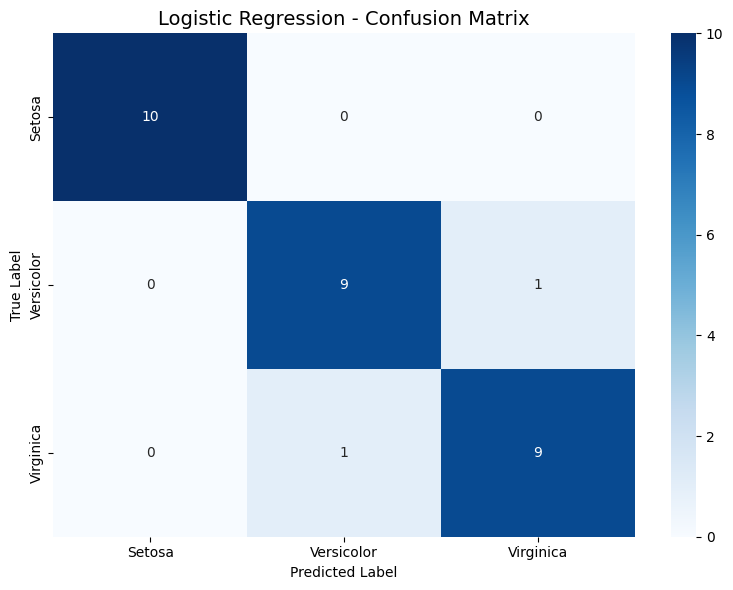

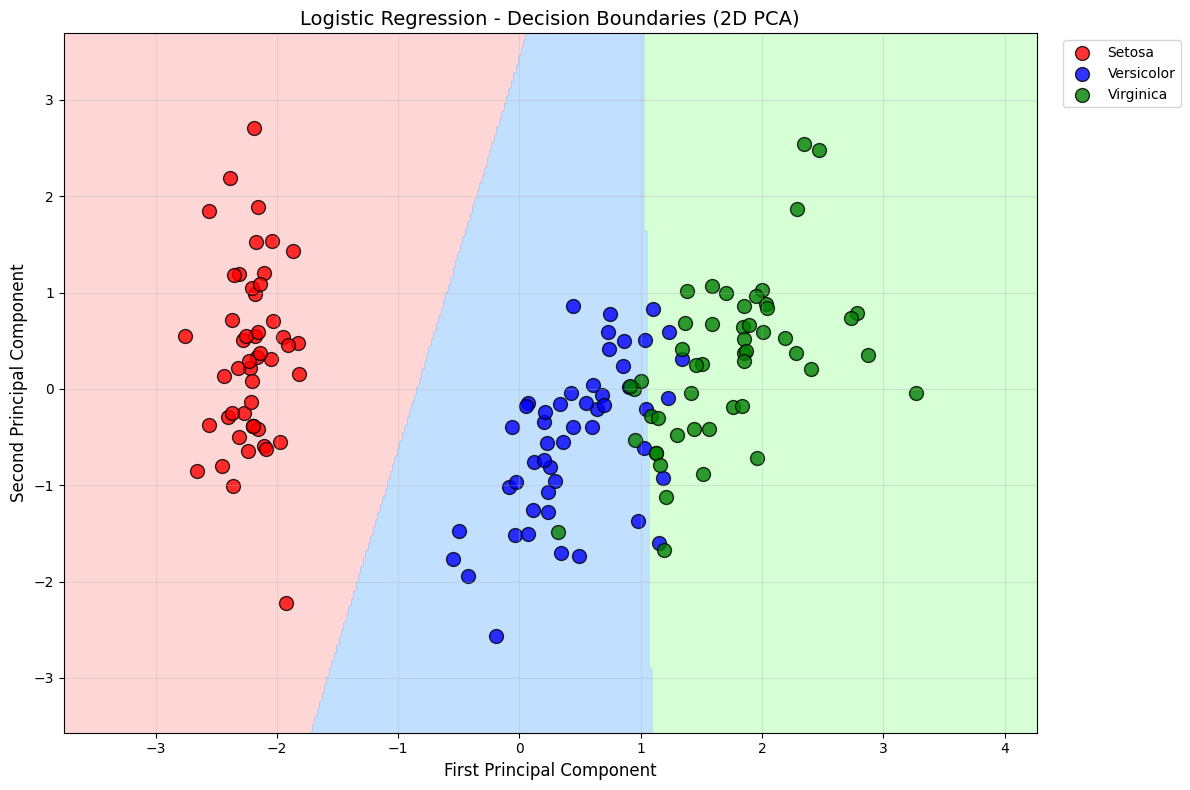

In [93]:
model = linear_model.LogisticRegression(random_state=42)
results = evaluate_model(
    model, "Logistic Regression", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results = {'Logistic Regression': results}

- Model 2: K-Nearest Neighbors


K-Nearest Neighbors Results
Cross-Validation Accuracy: 0.967 (+/- 0.062)
Individual CV scores: [0.91666667 1.         0.95833333 0.95833333 1.        ]
Test Set Accuracy: 0.933

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



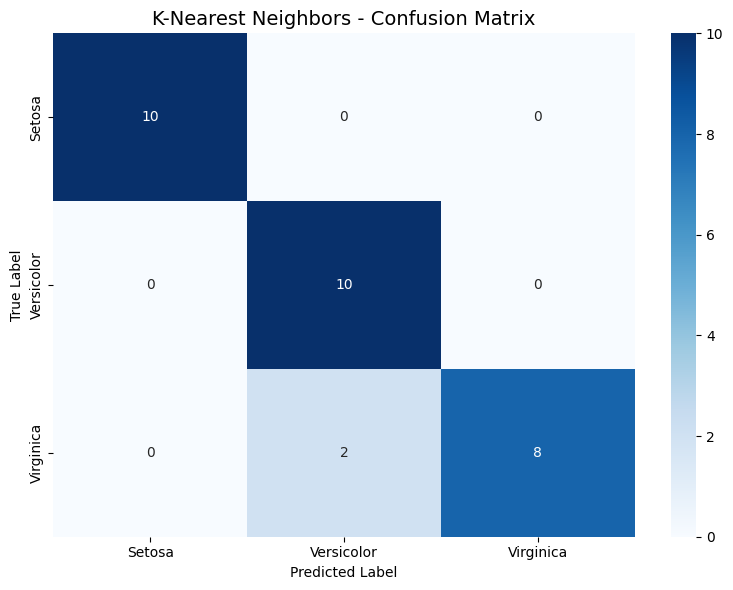

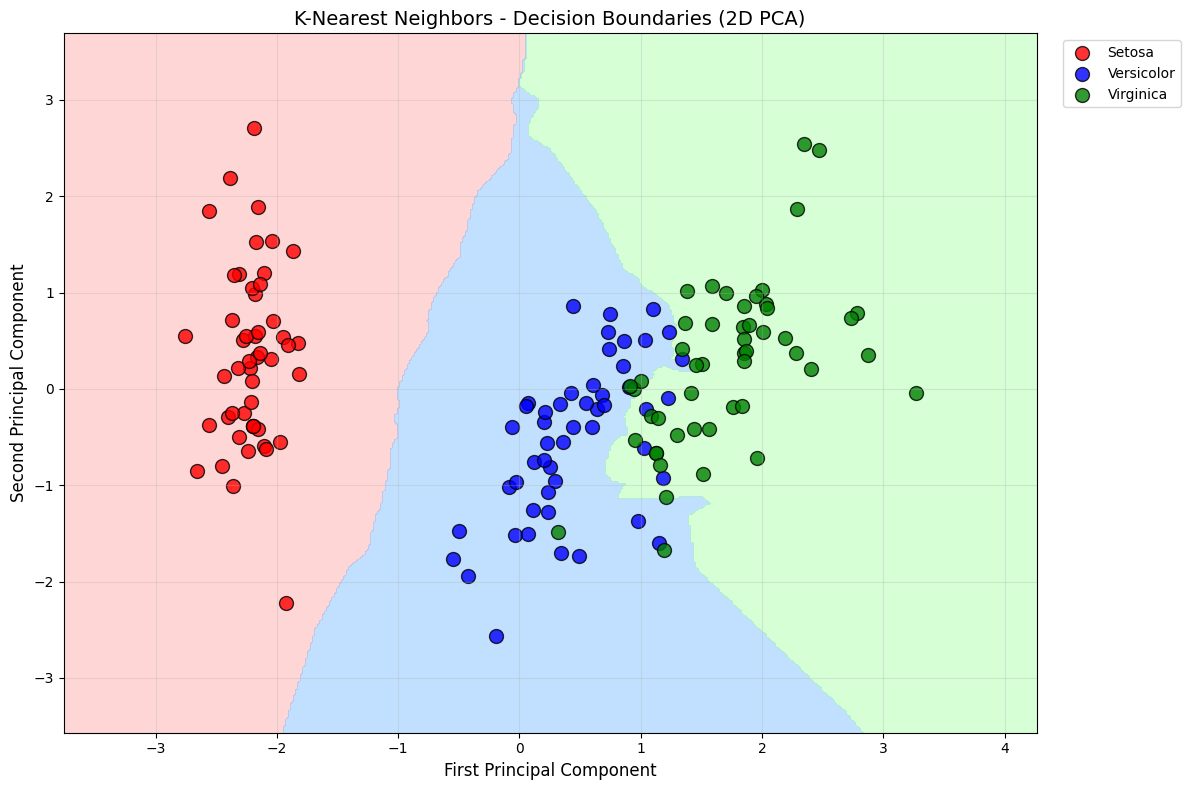

In [94]:
model = KNeighborsClassifier(n_neighbors=5)
results = evaluate_model(
    model, "K-Nearest Neighbors", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results['K-Nearest Neighbors'] = results


- Model 3: Decision Tree


Decision Tree Results
Cross-Validation Accuracy: 0.942 (+/- 0.041)
Individual CV scores: [0.91666667 0.95833333 0.95833333 0.95833333 0.91666667]
Test Set Accuracy: 0.900

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



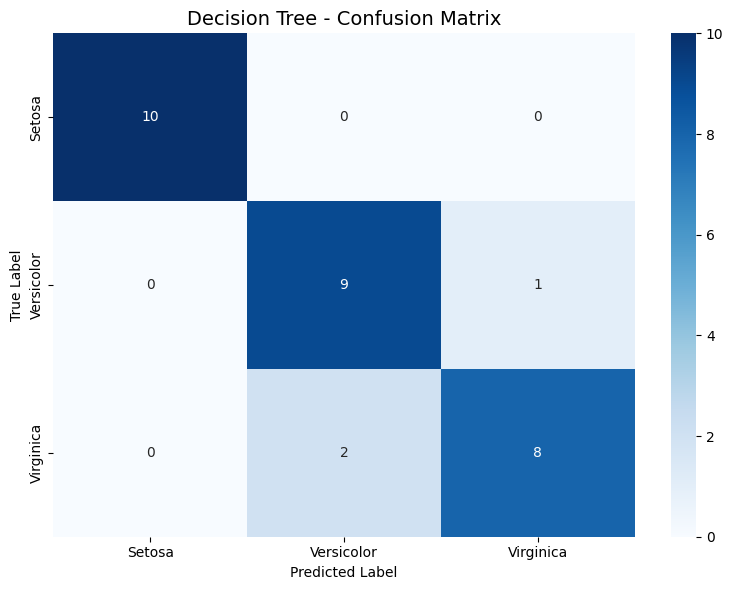

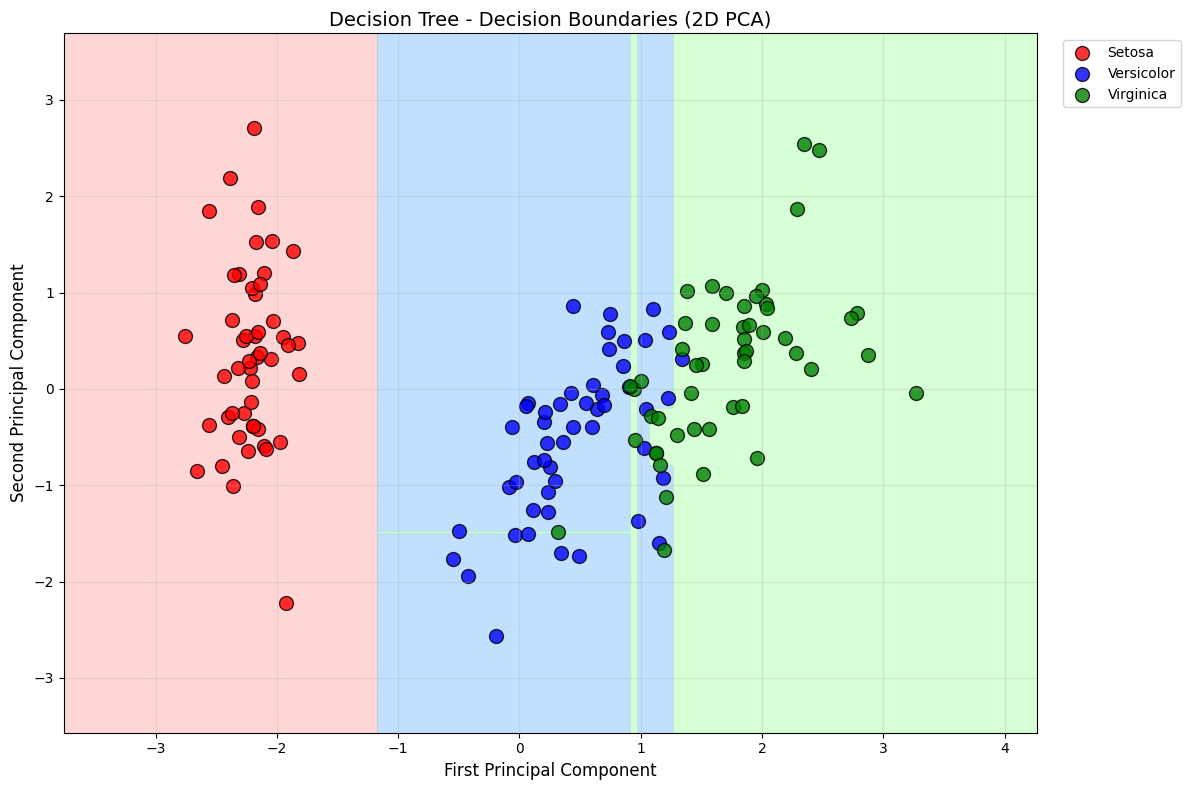

In [95]:
model = DecisionTreeClassifier(random_state=42, max_depth=5)
results = evaluate_model(
    model, "Decision Tree", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results['Decision Tree'] = results


- Model 4: Random Forest


Random Forest Results
Cross-Validation Accuracy: 0.950 (+/- 0.033)
Individual CV scores: [0.91666667 0.95833333 0.95833333 0.95833333 0.95833333]
Test Set Accuracy: 0.900

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.82      0.90      0.86        10
 Iris-virginica       0.89      0.80      0.84        10

       accuracy                           0.90        30
      macro avg       0.90      0.90      0.90        30
   weighted avg       0.90      0.90      0.90        30



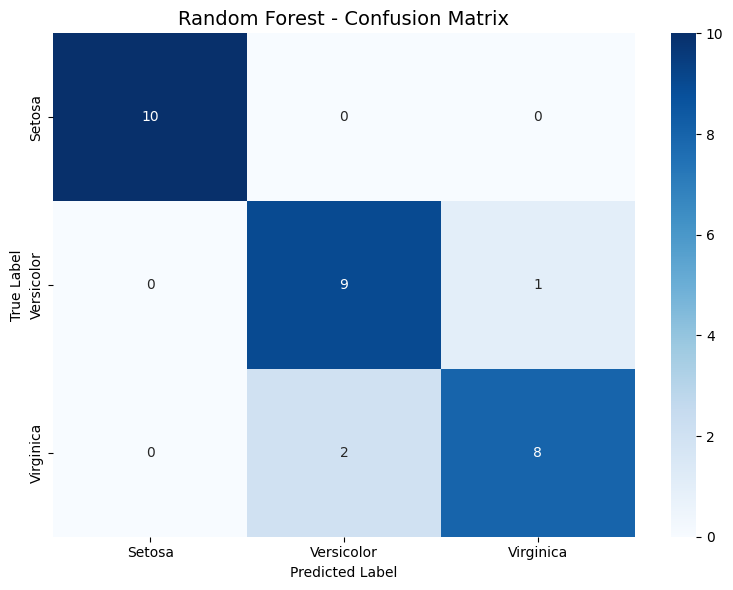

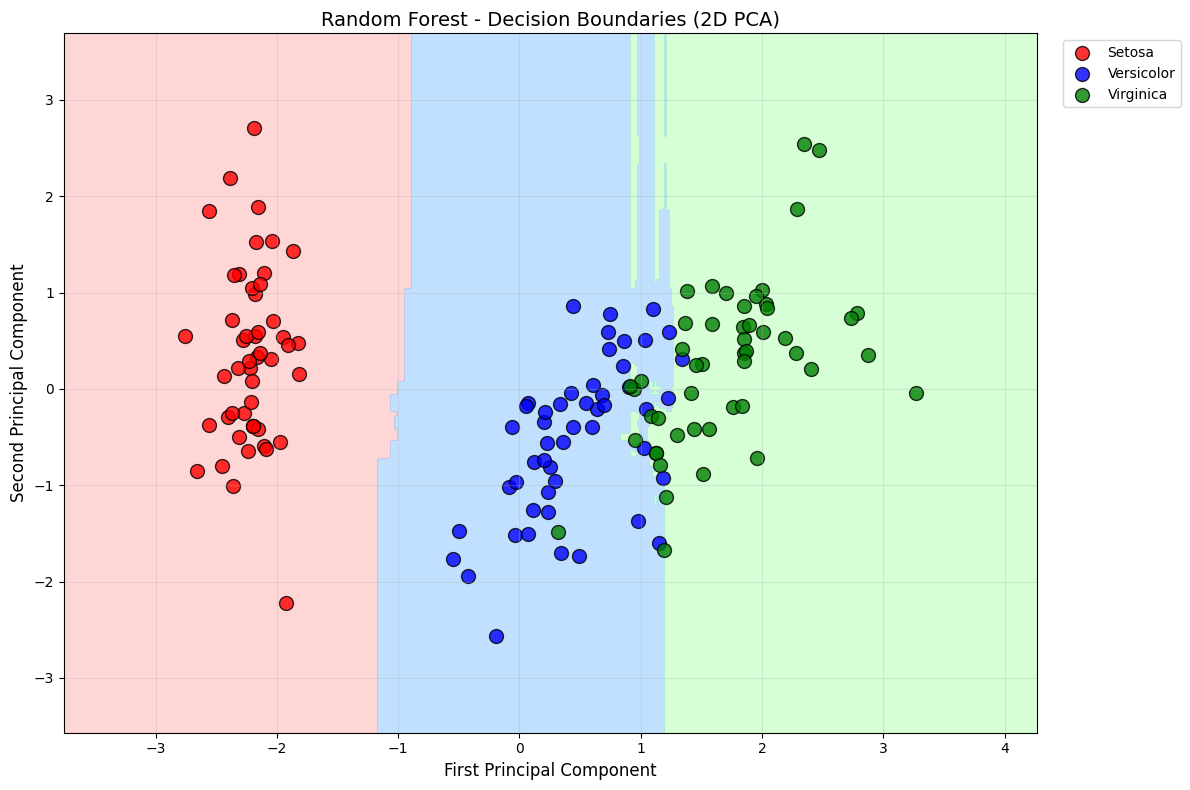

In [70]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
results = evaluate_model(
    model, "Random Forest", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results['Random Forest'] = results

- Model 5: Support Vector Machine


SVM Results
Cross-Validation Accuracy: 0.967 (+/- 0.062)
Individual CV scores: [0.91666667 1.         0.95833333 0.95833333 1.        ]
Test Set Accuracy: 0.967

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.91      1.00      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



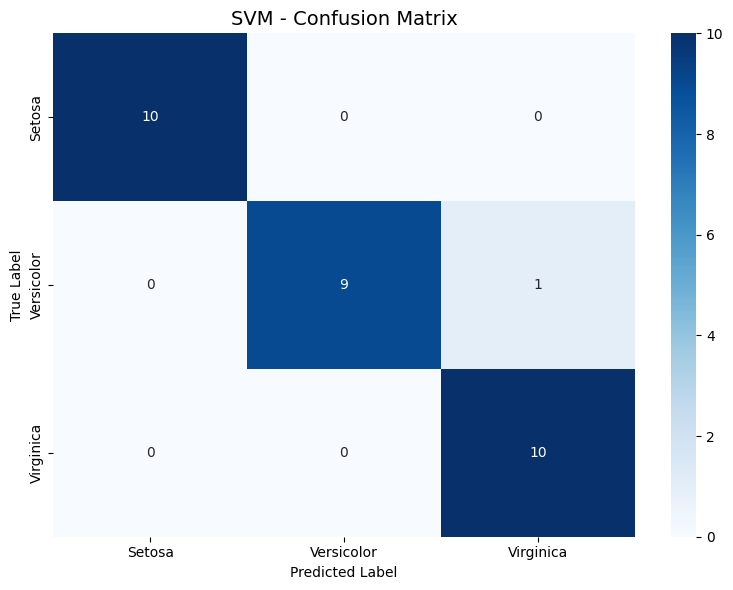

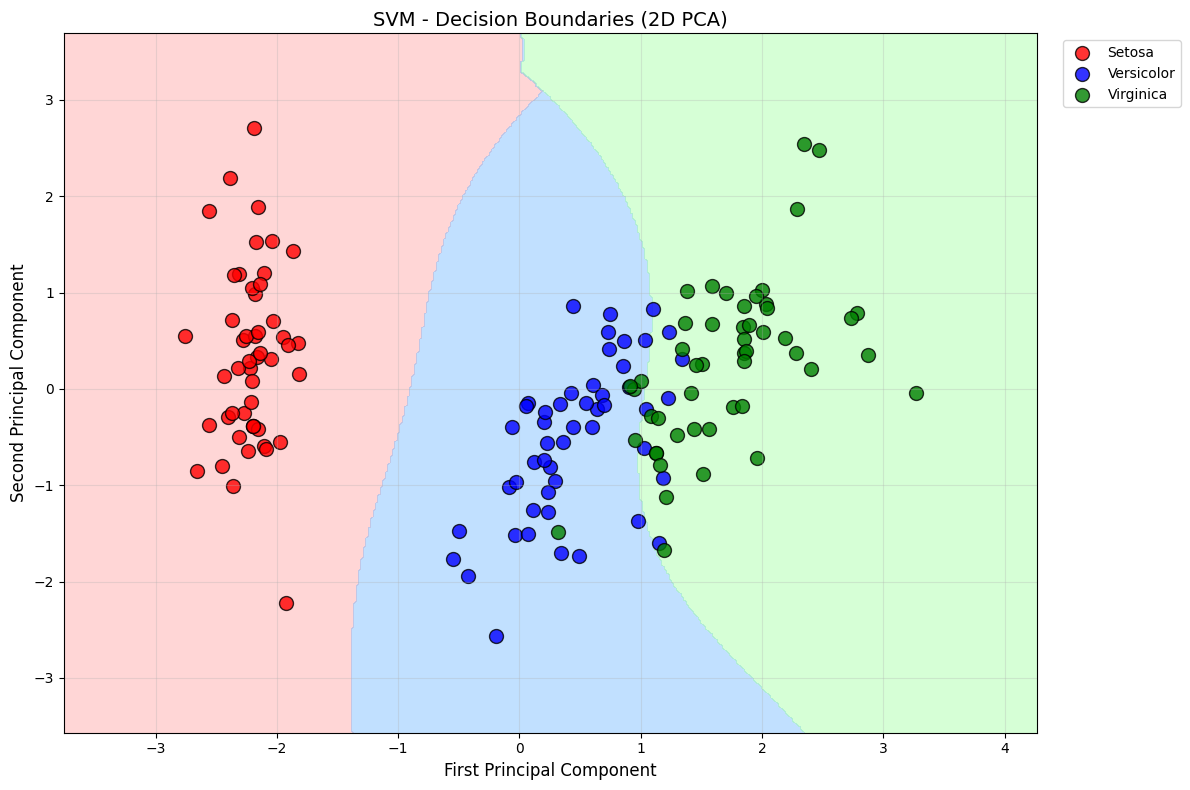

In [71]:
model = SVC(random_state=42)
results = evaluate_model(
    model, "SVM", 
    X_train_scaled, X_test_scaled, y_train, y_test,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results['SVM'] = results

- Model 6: Gradient Boost


XGBoost Results
Cross-Validation Accuracy: 0.950 (+/- 0.033)
Individual CV scores: [0.95833333 0.95833333 0.95833333 0.91666667 0.95833333]
Test Set Accuracy: 0.933

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



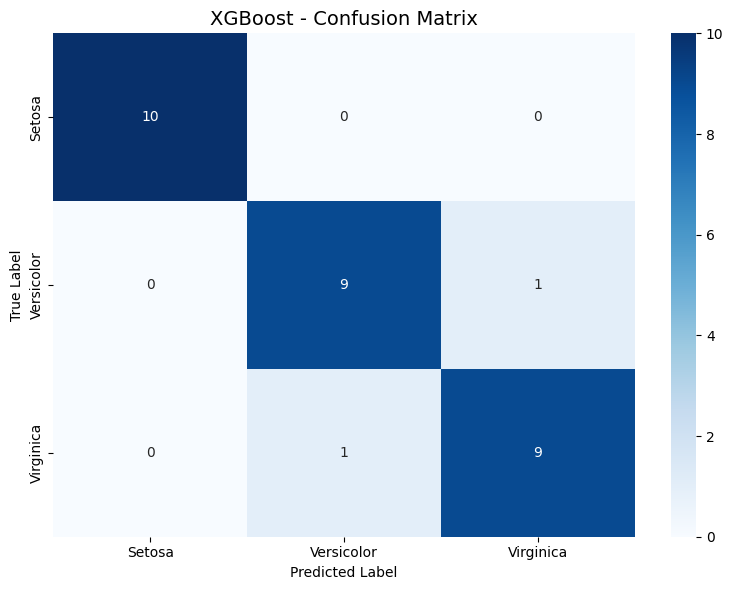

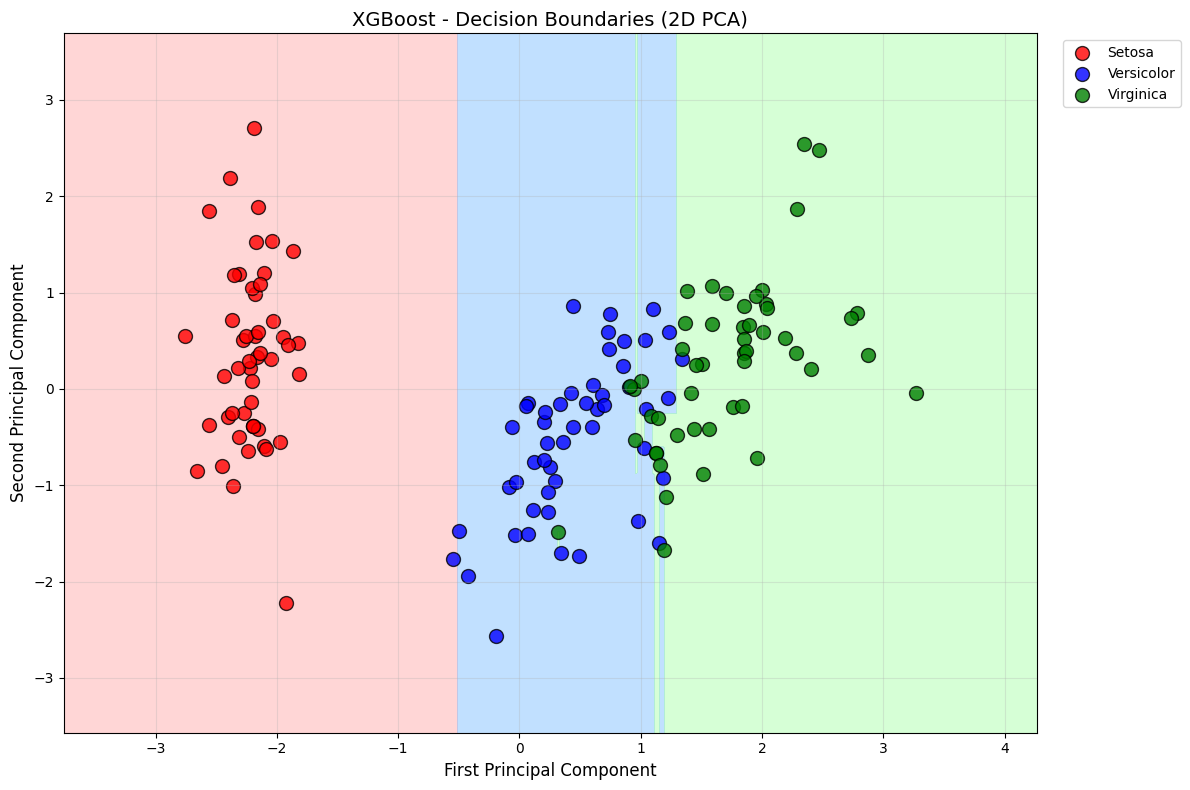

In [75]:
model = XGBClassifier(random_state=42, eval_metric='logloss')
label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_test_numeric = label_encoder.transform(y_test)
results = evaluate_model(
    model, "XGBoost", 
    X_train_scaled, X_test_scaled, y_train_numeric, y_test_numeric,
    X_train_2d, X_test_2d
)

# Store results for comparison
all_results['XGBoost'] = results

#### Section 4: Conclusion

In this section, I will compare the performances of these machine learning algorithms

In [110]:
algorithm_types = {
    'Logistic Regression': 'Linear',
    'K-Nearest Neighbors': 'Instance-Based', 
    'Decision Tree': 'Tree-Based',
    'Random Forest': 'Ensemble (Bagging)',
    'SVM': 'Linear',
    'XGBoost': 'Ensemble (Boosting)'
}

comparison_data = []
for algo_key, result in all_results.items():
    comparison_data.append({
        'Algorithm': result['model_name'],
        'Test Accuracy': result['test_accuracy'],
        'CV Mean': result['cv_mean'],
        'CV Std': result['cv_std'],
        'Algorithm Type': algorithm_types.get(algo_key, 'Other')
    })

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('Test Accuracy', ascending=False).reset_index(drop=True)
results_df['Rank'] = range(1, len(results_df) + 1)


print("\nPERFORMANCE RANKINGS")
print("-" * 100)
print(f"{'Rank':<4} | {'Algorithm':<18} | {'Test Accuracy':<12} | {'CV Mean±Std':<15} | {'Type':<25}")
print("-" * 100)

for _, row in results_df.iterrows():  
    cv_display = f"{row['CV Mean']:.3f} ± {row['CV Std']:.3f}"
        
    print(f"{row['Rank']:<5} {row['Algorithm']:<21} {row['Test Accuracy']:<15.3f} {cv_display:<17} {row['Algorithm Type']:<25}")

print("-" * 100)


PERFORMANCE RANKINGS
----------------------------------------------------------------------------------------------------
Rank | Algorithm          | Test Accuracy | CV Mean±Std     | Type                     
----------------------------------------------------------------------------------------------------
1     Logistic Regression   0.933           0.958 ± 0.026     Linear                   
2     K-Nearest Neighbors   0.933           0.967 ± 0.031     Instance-Based           
3     Decision Tree         0.900           0.942 ± 0.020     Tree-Based               
----------------------------------------------------------------------------------------------------


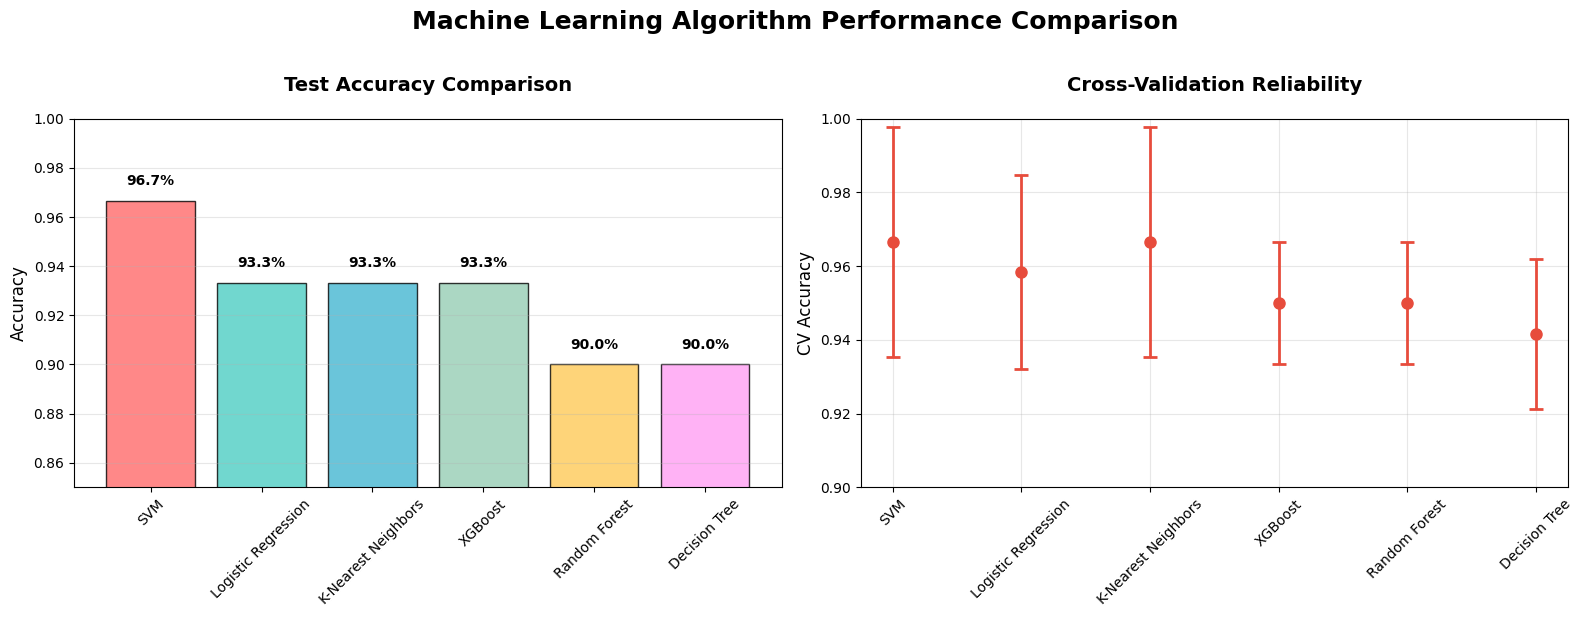

In [86]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Machine Learning Algorithm Performance Comparison', fontsize=18, fontweight='bold', y=1.02)

# 1. Test Accuracy Comparison (Bar Chart)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3']
bars = ax1.bar(results_df['Algorithm'], results_df['Test Accuracy'], color=colors, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_ylim(0.85, 1.0)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, results_df['Test Accuracy']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=10)

ax1.tick_params(axis='x', rotation=45)

# 2. Cross-Validation Scores with Error Bars
x_pos = range(len(results_df))
ax2.errorbar(x_pos, results_df['CV Mean'], yerr=results_df['CV Std'], 
             fmt='o', capsize=5, capthick=2, markersize=8, linewidth=2, color='#E74C3C')
ax2.set_title('Cross-Validation Reliability', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('CV Accuracy', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(results_df['Algorithm'], rotation=45)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.90, 1.0)

plt.tight_layout()
plt.show()
